In [ ]:
# Connect to Google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install ngboost

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 5.2 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=68428190d41eef28a69bc5d53a56485198efa071cc10dc519ae1bc631bffb922
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from ngboost import NGBRegressor
from ngboost.distns import Exponential, Normal, LogNormal
import seaborn as sns
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
#import dataset
fatigue_df = pd.read_csv('/content/drive/MyDrive/Datasets/Titanium_Alloy_UC.csv', encoding='latin1')
fatigue_df

,SL. Number,Number of Cycles,Stress (MPa),Solution Temperature (°C),Solution Time (hrs),Temperature Measurement (°C),Ann/Age. temp (cel),Ann/age time (hrs),Total Strain (%),R,...,C,N,O,H,Fe,Si,Sn,Nb,Mo,Zr
0,123,100000,860.00,932,0.0,25,704,2.0,0.0,0.5,...,0.00,0.0120,0.18,0.0000,0.20,0.00,0.0,0.0,0.0,0.0
1,126,100000,850.00,925,1.0,25,700,2.0,0.0,0.5,...,0.00,0.0120,0.18,0.0041,0.20,0.00,0.0,0.0,0.0,0.0
2,158,1000000,800.00,932,0.0,25,704,2.0,0.0,0.5,...,0.00,0.0120,0.18,0.0000,0.20,0.00,0.0,0.0,0.0,0.0
3,161,1000000,780.00,925,1.0,25,700,2.0,0.0,0.5,...,0.00,0.0120,0.18,0.0041,0.20,0.00,0.0,0.0,0.0,0.0
4,164,1000000,699.00,0,0.0,25,700,2.0,0.0,0.5,...,0.00,0.0130,0.19,0.0041,0.19,0.00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,18,249,915.24,1020,1.0,25,0,0.0,0.8,-1.0,...,0.05,0.0025,0.00,0.0040,0.00,0.34,4.0,0.7,0.5,3.7
216,27,325,910.82,1020,1.0,25,0,0.0,0.8,-1.0,...,0.05,0.0025,0.00,0.0040,0.00,0.34,4.0,0.7,0.5,3.7
217,31,370,907.55,1020,1.0,25,0,0.0,0.8,-1.0,...,0.05,0.0025,0.00,0.0040,0.00,0.34,4.0,0.7,0.5,3.7
218,41,444,900.00,1020,1.0,25,0,0.0,0.8,-1.0,...,0.05,0.0025,0.00,0.0040,0.00,0.34,4.0,0.7,0.5,3.7


In [ ]:
fatigue_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   SL. Number                    220 non-null    int64  
 1   Number of Cycles              220 non-null    int64  
 2   Stress (MPa)                  220 non-null    float64
 3   Solution Temperature (°C)     220 non-null    int64  
 4   Solution Time (hrs)           220 non-null    float64
 5   Temperature Measurement (°C)  220 non-null    int64  
 6   Ann/Age. temp (cel)           220 non-null    int64  
 7   Ann/age time (hrs)            220 non-null    float64
 8   Total Strain (%)              220 non-null    float64
 9   R                             220 non-null    float64
 10  Frequency (Hz)                220 non-null    float64
 11  Ti                            220 non-null    float64
 12  Al                            220 non-null    float64
 13  V    

In [ ]:
# Remove columns that are not needed
drop_cols = ['Number of Cycles','SL. Number'] # list the columns to drop along with target for independent feautures

# Use all remaining columns as features
features = fatigue_df.drop(drop_cols, axis=1)

# Use log transform of the number of cycles as targets
targets = np.log10(fatigue_df['Number of Cycles'])

# Display the features
features

,Stress (MPa),Solution Temperature (°C),Solution Time (hrs),Temperature Measurement (°C),Ann/Age. temp (cel),Ann/age time (hrs),Total Strain (%),R,Frequency (Hz),Ti,...,C,N,O,H,Fe,Si,Sn,Nb,Mo,Zr
0,860.00,932,0.0,25,704,2.0,0.0,0.5,60.0,89.148,...,0.00,0.0120,0.18,0.0000,0.20,0.00,0.0,0.0,0.0,0.0
1,850.00,925,1.0,25,700,2.0,0.0,0.5,50.0,89.140,...,0.00,0.0120,0.18,0.0041,0.20,0.00,0.0,0.0,0.0,0.0
2,800.00,932,0.0,25,704,2.0,0.0,0.5,60.0,89.148,...,0.00,0.0120,0.18,0.0000,0.20,0.00,0.0,0.0,0.0,0.0
3,780.00,925,1.0,25,700,2.0,0.0,0.5,50.0,89.140,...,0.00,0.0120,0.18,0.0041,0.20,0.00,0.0,0.0,0.0,0.0
4,699.00,0,0.0,25,700,2.0,0.0,0.5,90.0,89.100,...,0.00,0.0130,0.19,0.0041,0.19,0.00,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,915.24,1020,1.0,25,0,0.0,0.8,-1.0,0.2,84.900,...,0.05,0.0025,0.00,0.0040,0.00,0.34,4.0,0.7,0.5,3.7
216,910.82,1020,1.0,25,0,0.0,0.8,-1.0,0.2,84.900,...,0.05,0.0025,0.00,0.0040,0.00,0.34,4.0,0.7,0.5,3.7
217,907.55,1020,1.0,25,0,0.0,0.8,-1.0,0.2,84.900,...,0.05,0.0025,0.00,0.0040,0.00,0.34,4.0,0.7,0.5,3.7
218,900.00,1020,1.0,25,0,0.0,0.8,-1.0,0.2,84.900,...,0.05,0.0025,0.00,0.0040,0.00,0.34,4.0,0.7,0.5,3.7


In [ ]:
# Calculate the coverage percentage of values within a specified range
def coverage(y, yL, yH):
    return np.sum(100 / y.shape[0] * ((y>yL)&(y<yH)))

Run # 1 Fold # 1
[iter 0] loss=1.9627 val_loss=2.1894 scale=1.0000 norm=0.5090
[iter 100] loss=1.5393 val_loss=1.7514 scale=2.0000 norm=0.8468
[iter 200] loss=1.0948 val_loss=1.3169 scale=2.0000 norm=0.8513
[iter 300] loss=0.7424 val_loss=1.0233 scale=2.0000 norm=0.7989
[iter 400] loss=0.4632 val_loss=0.8630 scale=2.0000 norm=0.7297
== Early stopping achieved.
== Best iteration / VAL452 (val_loss=0.8405)
Pearson CC: 0.9463868122448086
R2 score: 0.8810735098840722
RMSE: 0.6135743860007128
MAE: 0.4210651618811326
Coverage: 88.63636363636363
Median Interval Width: 1.0948839941276152
Composite Metric: 0.8931074196610251


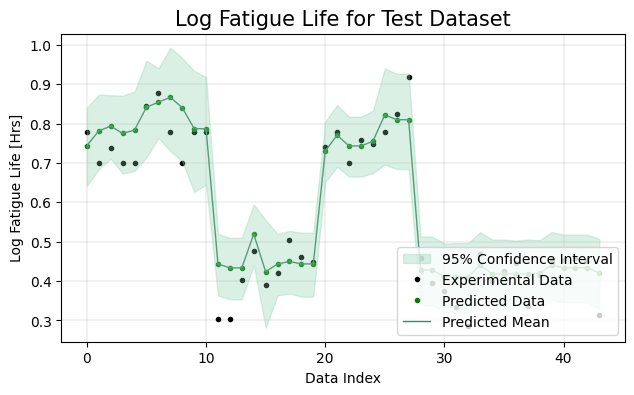

Run # 1 Fold # 2
[iter 0] loss=1.9729 val_loss=2.0631 scale=1.0000 norm=0.5138
[iter 100] loss=1.6134 val_loss=1.7127 scale=2.0000 norm=0.8609
[iter 200] loss=1.1458 val_loss=1.2769 scale=2.0000 norm=0.8693
[iter 300] loss=0.7600 val_loss=0.9866 scale=2.0000 norm=0.8335
[iter 400] loss=0.4576 val_loss=0.8857 scale=2.0000 norm=0.7633
== Early stopping achieved.
== Best iteration / VAL397 (val_loss=0.8848)
Pearson CC: 0.9529840506005868
R2 score: 0.8984271201604156
RMSE: 0.6055893532728112
MAE: 0.42473982593704157
Coverage: 93.18181818181816
Median Interval Width: 2.2847683085978936
Composite Metric: 0.808283921588714


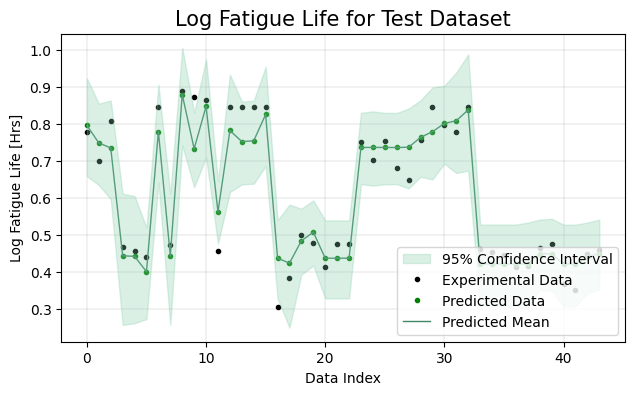

Run # 1 Fold # 3
[iter 0] loss=1.9729 val_loss=2.0510 scale=1.0000 norm=0.5132
[iter 100] loss=1.5911 val_loss=1.6645 scale=2.0000 norm=0.8566
[iter 200] loss=1.1366 val_loss=1.2418 scale=2.0000 norm=0.8668
[iter 300] loss=0.7730 val_loss=0.9571 scale=2.0000 norm=0.8200
[iter 400] loss=0.4949 val_loss=0.8362 scale=2.0000 norm=0.7628
== Early stopping achieved.
== Best iteration / VAL408 (val_loss=0.8344)
Pearson CC: 0.9533508918622167
R2 score: 0.9086137444324254
RMSE: 0.5773872857184118
MAE: 0.4329943164143323
Coverage: 97.72727272727272
Median Interval Width: 1.8278175835293657
Composite Metric: 0.8697296822366691


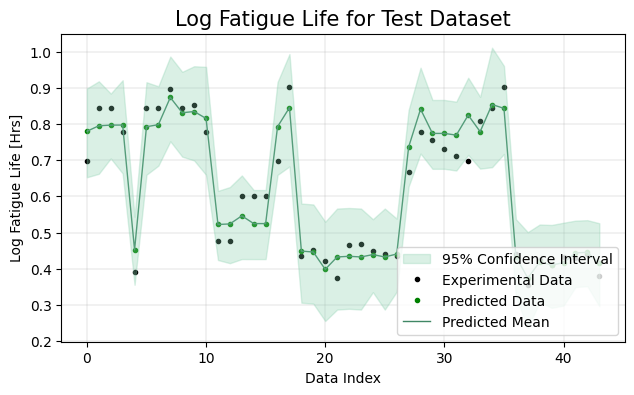

Run # 1 Fold # 4
[iter 0] loss=1.9238 val_loss=2.0817 scale=1.0000 norm=0.5285
[iter 100] loss=1.4164 val_loss=1.5618 scale=2.0000 norm=0.8682
[iter 200] loss=0.9897 val_loss=1.1540 scale=2.0000 norm=0.8753
[iter 300] loss=0.6478 val_loss=0.8934 scale=2.0000 norm=0.8258
[iter 400] loss=0.3773 val_loss=0.7794 scale=2.0000 norm=0.7596
== Early stopping achieved.
== Best iteration / VAL405 (val_loss=0.7792)
Pearson CC: 0.8210206578610476
R2 score: 0.6483953583598622
RMSE: 1.0205369492552658
MAE: 0.7090668070882346
Coverage: 88.63636363636363
Median Interval Width: 2.576883582358537
Composite Metric: 0.7617891395435459


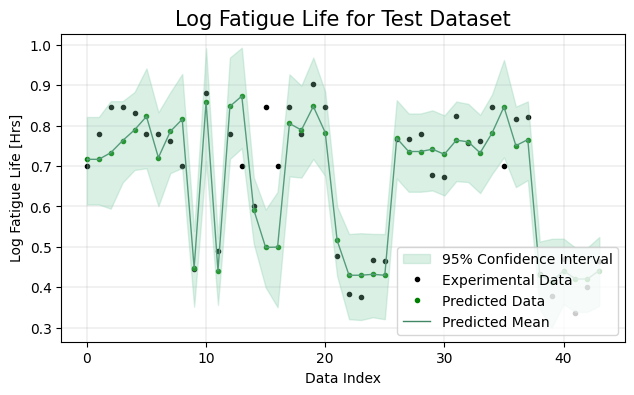

Run # 1 Fold # 5
[iter 0] loss=1.9968 val_loss=1.9895 scale=1.0000 norm=0.5075
[iter 100] loss=1.6053 val_loss=1.6018 scale=2.0000 norm=0.8489
[iter 200] loss=1.1445 val_loss=1.1751 scale=2.0000 norm=0.8594
[iter 300] loss=0.7726 val_loss=0.8872 scale=2.0000 norm=0.8141
[iter 400] loss=0.4658 val_loss=0.7707 scale=2.0000 norm=0.7435
== Early stopping achieved.
== Best iteration / VAL403 (val_loss=0.7704)
Pearson CC: 0.9632671376281285
R2 score: 0.9178706617995933
RMSE: 0.5779243790159199
MAE: 0.3925397345906159
Coverage: 95.45454545454544
Median Interval Width: 1.4140318760497874
Composite Metric: 0.8927084999142083


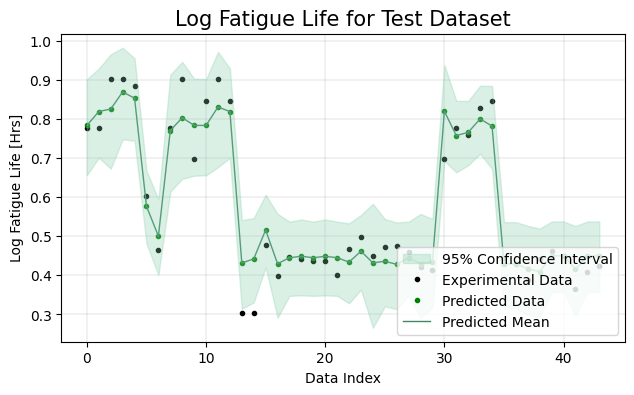

In [ ]:
# Evaluate multiple runs of the model
nruns = 1
nfolds = 5

# Metrics for performance evaluation
PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
RMSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)
MAPE = np.zeros_like(PearsonCC)

test_coverage = np.zeros_like(PearsonCC)
median_interval_width = np.zeros_like(PearsonCC)
composite_metric = np.zeros_like(PearsonCC)
for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=123+j)

        for i, (tr, ts) in enumerate(kf.split(targets)):

            # Display the run number
            print('Run #', j+1, "Fold #", i+1)

            X_train, X_test = features.iloc[tr], features.iloc[ts]
            y_train, y_test = targets[tr], targets[ts]
            X_train, X_val, y_train, Y_val =train_test_split(X_train, y_train, test_size=0.2, random_state=42)


            model = NGBRegressor(Dist=LogNormal, n_estimators=1000, learning_rate=0.005)
            model.fit(X_train, y_train, X_val=X_val, Y_val=Y_val, early_stopping_rounds=4)

            y_pred_test = model.predict(X_test)
            y_test_ngb = model.pred_dist(X_test)

            PearsonCC[j, i] = pearsonr(y_test, y_pred_test)[0]
            R2_score[j, i] = r2_score(y_test, y_pred_test)
            RMSE[j, i] = sqrt(mean_squared_error(y_pred_test, y_test))
            MAE[j, i] = np.mean(abs(y_pred_test-y_test))

            print(f'Pearson CC: {PearsonCC[j, i]}')
            print(f'R2 score: {R2_score[j, i]}')
            print(f'RMSE: {RMSE[j, i]}')
            print(f'MAE: {MAE[j, i]}')

            df_test_low = y_test_ngb.interval(0.95)[0]
            df_test_median = y_pred_test
            df_test_high = y_test_ngb.interval(0.95)[1]

            test_coverage[j, i] = coverage(y_test, df_test_low, df_test_high)

            print(f'Coverage: {test_coverage[j, i]}')
            # Prediction interval width
            median_interval_width[j, i] = np.median(df_test_high - df_test_low)
            print(f'Median Interval Width: {median_interval_width[j, i]}')

            # Composite metric that combines the coverage and the invers of interval width
            composite_metric[j, i] = 0.75*test_coverage[j, i]/100 + 0.25*(1/median_interval_width[j, i])
            print(f'Composite Metric: {composite_metric[j, i]}')

            # Plot the predictions
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
            iteration_list = [i for i in range(len(y_test))]

            y_pred = y_pred_test
            y_std = np.std(np.array(y_pred_test), axis=0)

            ## Uncertainty quantification plot
            ax[0].fill_between(iteration_list, np.log10(df_test_low), np.log10(df_test_high), alpha=0.3, color='#86cfac', zorder=5, label='95% Confidence Interval')
            ax[0].plot(iteration_list, np.log10(y_test), 'ko', markersize=3, label="Experimental Data")
            ax[0].plot(iteration_list, np.log10(y_pred), 'go', markersize=3, label="Predicted Data")
            ax[0].plot(iteration_list, np.log10(y_pred), '-', linewidth=1, color="#408765", label="Predicted Mean")
            ax[0].legend(loc=4, fontsize=10, frameon=True)
            ax[0].set_xlabel("Data Index", fontsize=10)
            ax[0].set_ylabel("Log Fatigue Life [Hrs]", fontsize=10)
            ax[0].set_title("Log Fatigue Life for Test Dataset", fontsize=15)
            ax[0].grid(True, which='major', linestyle='-', linewidth='0.25')
            fig.delaxes(ax[1])

            plt.show()

In [ ]:
# Data frame
df1 = pd.DataFrame({'Pearson CC': PearsonCC.flatten(), 'R2 Score': R2_score.flatten(), 'RMSE': RMSE.flatten(),
                    'MAE': MAE.flatten(), 'Coverage': test_coverage.flatten()},index=None)
df1

,Pearson CC,R2 Score,RMSE,MAE,Coverage
0,0.946387,0.881074,0.613574,0.421065,88.636364
1,0.952984,0.898427,0.605589,0.424740,93.181818
2,0.953351,0.908614,0.577387,0.432994,97.727273
3,0.821021,0.648395,1.020537,0.709067,88.636364
4,0.963267,0.917871,0.577924,0.392540,95.454545


In [ ]:
# Calculate mean values and standard deviations of the scores
PearsonCC_mean = np.mean(PearsonCC)
R2_score_mean = np.mean(R2_score)
RMSE_mean = np.mean(RMSE)
MAE_mean = np.mean(MAE)
test_coverage_mean = np.mean(test_coverage)

PearsonCC_std = np.std(PearsonCC)
R2_score_std = np.std(R2_score)
RMSE_std = np.std(RMSE)
MAE_std = np.std(MAE)
test_coverage_std = np.std(test_coverage)

# Data frame
df2 = pd.DataFrame({'Pearson CC Mean': PearsonCC_mean, 'Pearson CC Std': PearsonCC_std, 'R2 Score Mean': R2_score_mean, 'R2 Score Std': R2_score_std,
                  'RMSE Mean': RMSE_mean, 'RMSE Std': RMSE_std, 'MAE Mean': MAE_mean, 'MAE Std':MAE_std,
                   'RMSE Std': RMSE_std, 'Test Coverage Mean': test_coverage_mean, 'Test Coverage Std':test_coverage_std},index=[0])
df2

,Pearson CC Mean,Pearson CC Std,R2 Score Mean,R2 Score Std,RMSE Mean,RMSE Std,MAE Mean,MAE Std,Test Coverage Mean,Test Coverage Std
0,0.927402,0.053463,0.850876,0.101974,0.679002,0.171382,0.476081,0.117287,92.727273,3.636364


In [ ]:
# Data frame
df3 = pd.DataFrame({'Coverage': test_coverage.flatten(),  'Interval Width': median_interval_width.flatten(), 'Composite Metric': composite_metric.flatten()},index=None)
df3

,Coverage,Interval Width,Composite Metric
0,88.636364,1.094884,0.893107
1,93.181818,2.284768,0.808284
2,97.727273,1.827818,0.869730
3,88.636364,2.576884,0.761789
4,95.454545,1.414032,0.892708


In [ ]:
# Calculate mean values and standard deviations of the scores
test_coverage_mean = np.mean(test_coverage)

median_interval_width_mean = np.mean(median_interval_width)
composite_metric_mean = np.mean(composite_metric)

test_coverage_std = np.std(test_coverage)

median_interval_width_std = np.std(median_interval_width)
composite_metric_std = np.std(composite_metric)

# Data frame
df4 = pd.DataFrame({'Coverage Mean': test_coverage_mean, 'Coverage Std': test_coverage_std,
                    'Interval Width Mean': median_interval_width_mean, 'Interval Width Std':median_interval_width_std,
                   'Composite Metric Mean': composite_metric_mean, 'Composite Metric Std': composite_metric_std,},index=[0])
df4

,Coverage Mean,Coverage Std,Interval Width Mean,Interval Width Std,Composite Metric Mean,Composite Metric Std
0,92.727273,3.636364,1.839677,0.54362,0.845124,0.051912
